# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

### TODO:

- Use `tf.ragged_constant`, i. e. `tf`'s ragged tensor capability to efficiently
pad $C$ and $N$ an transform from $C_T$ to $C_{DN_{\mathrm{max}}}$ or $W_T$ and 
$W_{DN_{\mathrm{max}}}$. Construct with `tf.RaggedTensor.from_row_lengths()`.
- Use `tf.sparse` to operate with $C_{DN_{\mathrm{max}}K}$ and $C_{TK}$

In [940]:
from collections.abc import Sequence
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [941]:
from importlib import reload  

import topicflow.utils as tp_utils
import topicflow.data as tp_data

tp_utils = reload(tp_utils)
tp_data = reload(tp_data)


### **Sampling Behaviour of `tfp.Distributions`**

In [942]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[0., 0., 1.], 
                     [1., 0., 0.]])
print(probs.shape)
tfd.Categorical(probs=probs).sample(4).numpy()

(2, 3)


array([[2, 0],
       [2, 0],
       [2, 0],
       [2, 0]])

In [943]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
tfd.Dirichlet(conc).sample().numpy()

array([[0.02140409, 0.01427036, 0.9643255 ],
       [0.38862276, 0.16176145, 0.44961584]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

### Understand The indices in this Notebook

- $K$ is the number of topics 
- $D$ is the number of documents
- $I_d$ is the number of words in document $d$
- $N_{\mathrm{max}}$ is the maximum number of words per doument, i. e. $N_{\mathrm{max}} = \max_d \{I_d\}$
- $T$ is the total number of words, i. e. $T = \sum_d I_d$
- $V$ is the vocabulary size which should be a square of an integer for the visualization purposes of this notebook

### **1. Specify global parameters**

In [944]:
sqrtV = 5    # Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
D     = 1000  # Number of documents
N     = 100  
V = int(sqrtV**2)
K = 2*sqrtV
alpha = 1.

### **2. Generating Data**

In [945]:
data = tp_data.squareLDDocuments(D, sqrtV, N_words_fixed=N, alpha=alpha)
Theta, Pi, C_DId, C_DIdK, W_DId = data.extract_params()

In [946]:
int(tf.reduce_max(W_DId))

24

In [892]:
C_DIdK.shape

TensorShape([1000, None, 10])

In [893]:
## To extract topic-word assignments and document-words for a 
print("Topics for the Words in Document d=11:")
print(C_DId[11])
print("\nWords in Document d=11:")
print(W_DId[11])

Topics for the Words in Document d=11:
tf.Tensor(
[8 8 1 8 8 8 3 8 1 1 8 4 0 6 3 1 9 8 8 4 8 1 9 1 7 3 0 3 8 8 4 3 8 9 3 9 6
 1 3 8 9 2 3 8 3 8 8 5 9 6 3 1 5 0 0 9 3 1 1 4 3 8 0 9 5 8 1 0 9 0 1 1 3 8
 3 3 8 3 0 3 0 7 3 3 0 8 9 8 0 5 9 3 3 7 5 2 0 8 5 0 1 3 5 1 5 0 5 8 5 8 3
 9 8 3 8 8 8 3 0 6 3], shape=(121,), dtype=int32)

Words in Document d=11:
tf.Tensor(
[23 18  8 18 18 13 18 23  9  9 18 21  3  1 19  7 19  3 18 20  8  5 19  8
  2 18  0 18 13 18 20 18  3 19 16  9 16  9 18 18  9 12 15  8 16  8 23 10
 24 21 19  8  5  2  2  9 17  5  5 20 17  8  2 19  0  8  6  3  4  2  8  5
 16 23 15 18 18 17  1 18  2  2 18 17  0 13  4  8  0 15 14 16 16 22 20 10
  1  8  0  1  5 18  0  5  0  0 20 13 20  3 16  4  3 18  3  3 23 16  4 16
 16], shape=(121,), dtype=int32)


### **3. Checking Shapes**

In [894]:
## For development purposes:
def print_all_shapes():
    print("Π-Shape (D docs x K topics)")
    print(Pi.shape)
    print("\nΘ-Shape (K topic x V vocab)")
    print(Theta.shape)
    print("\nC_DIdK-Shape (Topic for each word T=sum_d I_d)")
    print(C_DId.shape)
    print("\nC_DIdK-Shape (one-hot for each topic k in {1, K})")
    print(C_DIdK.shape)
    print("\nW-Shape (sum_d I_d words)")
    print(W_DId.shape)

In [895]:
print_all_shapes()

Π-Shape (D docs x K topics)
(1000, 10)

Θ-Shape (K topic x V vocab)
(10, 25)

C_DIdK-Shape (Topic for each word T=sum_d I_d)
(1000, None)

C_DIdK-Shape (one-hot for each topic k in {1, K})
(1000, None, 10)

W-Shape (sum_d I_d words)
(1000, None)


## **Visualization**

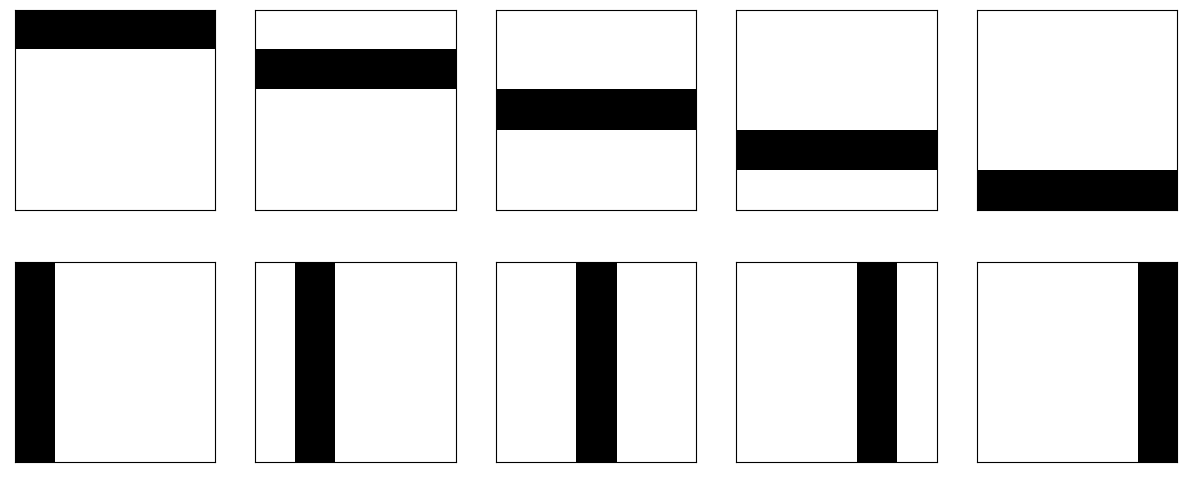

In [896]:
fig = tp_utils.visualize_topics(Theta, 2, int(Theta.shape[0] / 2))

Presenting documents [102 435 860 270 106  71 700  20 614 121]


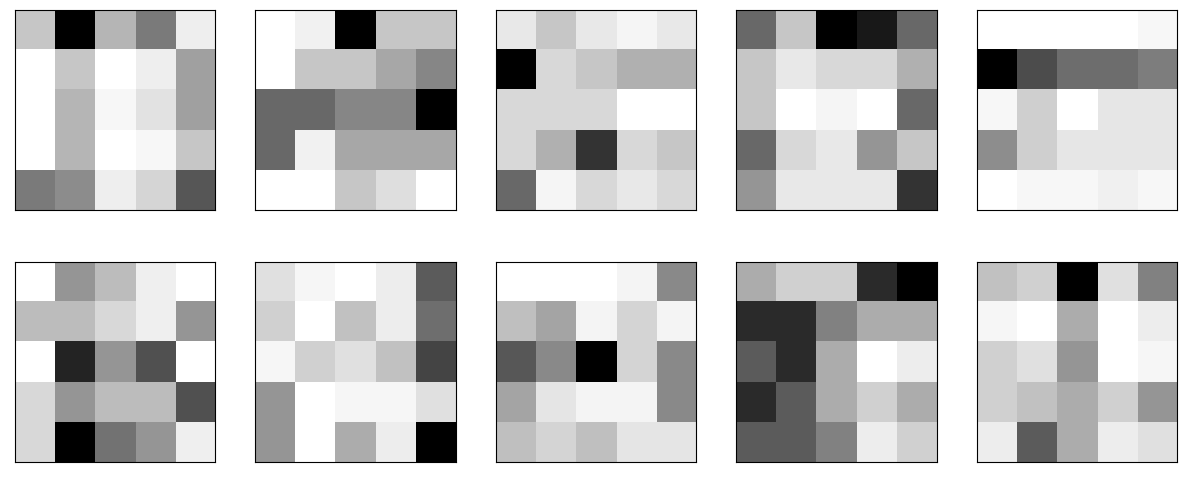

In [897]:
fig = tp_utils.visualize_random_docs(W_DId, sqrt_V=sqrtV)

## **Gibbs Sampler**

### **N-Tensor**
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
as much as possible. Due to the fact, that the document lengths are variable there is the choice between looping over the number of documents or padding the documents to a unique length. The padding does not need a word-token, it can be done by padding the $C$ matrix with $0$, therefore it will not affect $N$. Then the counting can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

#### 1. Multiloop over all Dimensions

Mainly for test purposes. Horribly slow.

In [898]:
def multiloop_N_tensor(W_DId, C_DIdK, V=V, verbose=False):

    ragged = any([x==None for x in W_DId.shape.as_list()])
    print(f"Is ragged? - {ragged}")

    K = C_DIdK.shape[-1]
    D = C_DIdK.shape[0]
    N_DKV = np.zeros(shape=(D, K, V))

    if ragged:
        W_DId  = W_DId.to_list() 
        C_DIdK = C_DIdK.to_list() 
    else:
        W_DId  = W_DId.numpy() 
        C_DIdK = C_DIdK.numpy() 

    if verbose:
        iterator = tqdm(range(D))
    else:
        iterator = range(D)
    
    for d in iterator:
        for k in range(K):
            for v in range(V):
                if ragged:
                    zip_it = zip(W_DId[d], np.array(C_DIdK[d])[:, k])
                else:
                    zip_it = zip(W_DId[d], np.array(C_DIdK[d, :, k]))
                for w_di, c_dik in zip_it:
                    if w_di == v and c_dik == 1:
                        N_DKV[d, k, v] += 1

    return N_DKV

##### Test and Benchmark

In [899]:
# N_test1 = multiloop_N_tensor(W_DId, C_DIdK)

In [900]:
# %timeit multiloop_N_tensor(W_DId, C_DIdK, verbose=False)

#### 2. Vectorized with Padding using `tf`

In [901]:
C_DIdK.shape

TensorShape([1000, None, 10])

In [902]:
## Actual n-Tensor
@tf.function
def tf_N_tensor(W_DId, C_DIdK, V=V):

    if any([x==None for x in C_DIdK.shape]):
        if C_DIdK.row_splits.dtype != tf.int32:
            C_DIdK = C_DIdK.with_row_splits_dtype(tf.int32)

    ## Extracting shapes
    D = W_DId.shape[0]
    K = C_DIdK.shape[-1]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to V+1 instead from 0 to V. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_DId + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_DIdK_int = tf.cast(C_DIdK, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_DIdK_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DIdKVp1 = tf.one_hot(C_Dot_W, V+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DIdKV = N_DIdKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    N_DKV = tf.reduce_sum(N_DIdKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

In [903]:
N_test2 = tf_N_tensor(W_DId, C_DIdK)
# np.all(N_test2 == N_test1)

##### Test and Benchmark

In [904]:
# %timeit tf_N_tensor(W_DId, C_DIdK)

In [905]:
print(f"For D={D}, V={V} and I_d~{N} The tf Version is about a factor {round(101./5., 1)} more efficient than the list version.")

For D=1000, V=25 and I_d~100 The tf Version is about a factor 20.2 more efficient than the list version.


### **Sampling $C$**

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^{I_d} \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution. The dependence of $I_d$ is somewhat entangled in the $w_{di}$ index of $\Theta_{kw_{di}}$. A fully vectorized solution without loop over $D$ therefore again needs padding.

https://youtu.be/z2q7LhsnWNg?t=3878

In [906]:
try:
    Nmax = int(tf.reduce_max(W_DId.nested_row_lengths()[0]))
except:
    Nmax = N

In [907]:
## Vectorized C-Sampling (W_DNmax must be padded!)
@tf.function
def sample_C(Theta, Pi, W_DId, Nmax: int):
    ## Extracting shapes
    ragged = any([x==None for x in W_DId.shape])
    K = Pi.shape[-1]
    V = Theta.shape[1]

    # Padding
    if ragged:
        W_DNmax = W_DId.to_tensor(0)
        mask = W_DId.to_tensor(V+1) != V+1
    if not ragged:
        W_DNmax = W_DId

    ## Numerator
    Theta_DNmaxK = tf.gather(tf.transpose(Theta), W_DNmax) 
    Pi_block  = tf.stack(Nmax * [Pi], axis=1)
    numerator = tf.math.multiply(Pi_block, Theta_DNmaxK)

    ## Dividing by Denominator
    # denominator = tf.reduce_sum(numerator, axis=-1)

    ## Sampling
    C_DNmax_dist = tfd.Categorical(probs=numerator)
    C_DNmax      = C_DNmax_dist.sample()
    if ragged:
        C_DId = tf.ragged.boolean_mask(C_DNmax, mask)
        C_DId = C_DId.with_row_splits_dtype(tf.int32)
    if not ragged:
        C_DId = C_DNmax

    # ## One-Hot-Encoding
    C_DIdK = tf.one_hot(C_DId, K, axis=-1)

    return C_DIdK

In [908]:
sample_C(Theta, Pi, W_DId, Nmax).shape

TensorShape([1000, None, 10])

#### Test

In [909]:
# W_temp      = W_DId.to_tensor(0)
# mask_temp   = W_DId.to_tensor(V+1) != V+1
# W_temp      = W_temp.numpy()
# Pi_temp     = tf.stack(Nmax * [Pi], axis=1)

In [910]:
# Theta_1 = tf.gather(tf.transpose(Theta), W_temp)
# numerator_1 = tf.math.multiply(Pi_temp, Theta_1)

In [911]:
## For Tets purposes: Calculate Theta_KW in loop
# Theta_DNmaxK_loop = np.zeros(shape=(D, Nmax, K))
# for d in tqdm(range(D)):
#     for i in range(Nmax):
#         for k in range(K):
#             Theta_DNmaxK_loop[d, i, k] = Theta[k, W_temp[d, i]]

# assert np.all(Theta_DNmaxK_loop == Theta_1)
# numerator_loop = tf.math.multiply(Pi_temp, Theta_DNmaxK_loop)
# assert np.all(numerator_loop == numerator_1)

In [912]:
# C_temp_dist = tfd.Categorical(probs=numerator_1)
# C_temp      = C_temp_dist.sample()

### **Sampling $\Theta$ and $\Pi$**

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot}) \, .
    \end{align*}
$$
$\Theta$ and $\Pi$ are neither dependent on the number of words per document nor do they have an $I_d$ dimension. Therefore it is much easier to sample them:

In [913]:
@tf.function
def sample_Theta(N_DKV, beta):
    dist_Theta = tfd.Dirichlet(beta + tf.reduce_sum(N_DKV, axis=0))
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    dist_Pi = tfd.Dirichlet(alpha + tf.reduce_sum(N_DKV, axis=-1))
    Pi      = dist_Pi.sample()
    return Pi

#### Test

In [914]:
# ## Random Initialization of Prior Alpha and Beta.
# #  They do not acutally matter much but could be optimized by Type II MAP or MLE.
# beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
# alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

# ## Calculate one N_DKV for test purposes
# W_DNmax, C_DNmaxK = padd_CW(W_T, C_TK, N_idx)
# N_test = tf_N_tensor(W_DNmax, C_DNmaxK)

In [915]:
# test_Theta = sample_Theta(N_test, beta)
# test_Pi    = sample_Pi(N_test, alpha)

# assert test_Theta.shape == Theta.shape
# assert test_Pi.shape == Pi.shape

### **Main Loop**

Later: Add `@tf.function` decorator to `drop_pad_C` and replace `padd_CW` with `tf_padd_CW` in main loop.

In [916]:
Nmax = int(np.max(data.get_doc_lengths()))
Ntotal = int(np.sum(data.get_doc_lengths()))

In [936]:
N_iter = 200

C_Ntotal  = tf.constant(np.random.randint(0, K, size=Ntotal))
C_DId_ = tf.RaggedTensor.from_row_lengths(
    values=C_Ntotal,
    row_lengths=W_DId.nested_row_lengths()[0])
C_DIdK_ = tf.one_hot(C_DId_, K, axis=-1)

beta  = tf.ones(shape=(K, V), dtype=tf.float32)
alpha = tf.ones(shape=(D, K), dtype=tf.float32)

Note that `W_T` and `N_idx` are fixed since they are observable from the data and do therefore not have to be initialized.

First iteration takes a while brcause of tracing of `drop_pad_C` and `tf_pad_CW`:

In [918]:
if data.uniform_doclengths:
    C_DIdK_ = C_DIdK_.to_tensor()

In [919]:
Theta_store = []
for iter in tqdm(range(N_iter)):

    ## Calculate N_DKV_ from W_DNmax and C_DNmaxK
    N_DKV_ = tf_N_tensor(W_DId, C_DIdK_)
    
    ## Sample Theta_ and Pi_ from N_DKV_ and priors
    Theta_ = sample_Theta(N_DKV_, beta)
    Pi_    = sample_Pi(N_DKV_, alpha)

    ## Sample C_DNmaxK from Theta, Pi and N_DKV_
    C_DIdK_ = sample_C(Theta_, Pi_, W_DId, Nmax)
    
    Theta_store.append(Theta_)

100%|██████████| 200/200 [00:08<00:00, 22.33it/s]


In [920]:
Theta_store = tf.stack(Theta_store, axis=-1)

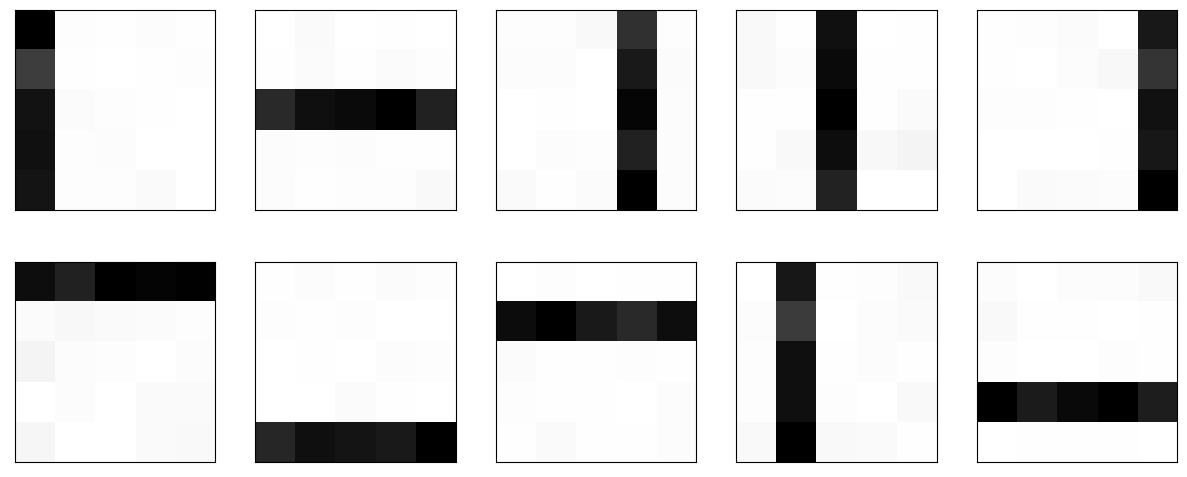

In [921]:
fig = tp_utils.visualize_topics(Theta_, 2, int(Theta.shape[0] / 2))